![Practicum AI Logo image](images/practicum_ai_logo.png) <img src='images/practicumai_deep_learning.png' alt='Practicum AI: Deep Learning Foundations icon' align='right' width=50>

***
# Hyperparameter Optimization

Amelia's nutrition study is going so well that her colleagues have heard about her growing AI skills! An entomologist colleague reached out to Amelia for help with their project. They would like to classify images as being a bee, a wasp, some other insect, or none of these.

Luckily, the entomologist colleague knows about the popular online repository of datasets, Kaggle, and already found a great dataset of images to use! [Check out the dataset information](https://www.kaggle.com/datasets/jerzydziewierz/bee-vs-wasp). [![Image of bees and wasps from the dataset cover image](images/bees_wasps_dataset-cover.png)]((https://www.kaggle.com/datasets/jerzydziewierz/bee-vs-wasp))


## 1. Import the libraries we will use

In [2]:
import tensorflow as tf   # Import the TensorFlow library, which provides tools for deep learning.
import pandas as pd  # Import the pandas library, used for data manipulation and analysis.

# Used for data management
import requests
import os
import time
import tarfile

import matplotlib.pyplot as plt  # Import the matplotlib library for plotting and visualization.
# This line allows for the display of plots directly within the Jupyter notebook interface.
%matplotlib inline  
 
# Import Keras libraries
from tensorflow.keras.models import Sequential  # Import the Sequential model: a linear stack of layers from Keras module in TensorFlow.
from tensorflow.keras.layers import Dense  # Import the Dense layer: a fully connected neural network layer from Keras module in TensorFlow.
from tensorflow.keras.layers import Flatten  # Import the Flatten layer: used to convert input data into a 1D array from Keras module in TensorFlow.
from tensorflow.keras.losses import SparseCategoricalCrossentropy  # Import the SparseCategoricalCrossentropy loss function from Keras module in TensorFlow.
from tensorflow.keras import layers 
from tensorflow.keras import losses
from sklearn.metrics import confusion_matrix 
import numpy as np 

## 2. Getting the data

Even once we have identified the dataset we want to use, getting it can be a challenge. Many AI datasets are large, require authentication even for free datasets, and may require some cleanup before working with them.

You can download the data from Kaggle, but need a free account. Additional steps are also needed to get the data into a usable format.

Git and GitHub.com are generally not well suited to large files (GitHub's limit is generally about 100Mb per file). And if we add all the images individually to the repository, the about 20,000 image files make operations take a long time.

If you are doing this as part of a workshop, we will provide the path to the data. 

We do have the dataset [hosted for download from Dropbox here as a `tar.gz` file](https://www.dropbox.com/s/x70hm8mxqhe7fa6/bee_vs_wasp.tar.gz?dl=0) that you can download and should be ready to use. 

### If needed, download the dataset

The following code block is quite large. **You do not need to understand everything!** This block will look for the data files required for this notebook in some common locations. If it can't find the data, it will ask if you know where it is. If you do, answer yes and provide the path to the data (up to and including the `bee_vs_wasp` folder name). If not, it will ask if you want to download it. If you answer yes, it will download the data and extract it into your data folder.

In [3]:
def download_file(url="https://www.dropbox.com/s/x70hm8mxqhe7fa6/bee_vs_wasp.tar.gz?dl=1", filename="bee_vs_wasp.tar.gz"):

    # Download the file using requests
    response = requests.get(url, stream=True)

    # Create a file object and write the response content in chunks
    with open(filename, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    # Wait for the file to finish downloading
    while not os.path.exists(filename):
        time.sleep(1)

    # Print a success message
    print(f"Downloaded {filename} successfully.")

def extract_file(filename, data_folder):
    # Check if the file is a tar file
    if tarfile.is_tarfile(filename):
        # Open the tar file
        tar = tarfile.open(filename, "r:gz")
        # Extract all the files to the data folder
        tar.extractall(data_folder)
        # Close the tar file
        tar.close()
        # Print a success message
        print(f"Extracted {filename} to {data_folder} successfully.")
    else:
        # Print an error message
        print(f"{filename} is not a valid tar file.")
    
def manage_data(folder_name='bee_vs_wasp'):
    '''Try to find the data for the exercise and return the path'''
    
    # Check common paths of where the data might be on different systems
    likely_paths= [os.path.normpath(f'/blue/practicum-ai/share/data/{folder_name}'),
                   os.path.normpath(f'/project/scinet_workshop2/data/{folder_name}'),
                   os.path.join('data', folder_name),
                   os.path.normpath(folder_name)]
    
    for path in likely_paths:
        if os.path.exists(path):
            print(f'Found data at {path}.')
            return path

    answer = input(f'Could not find data in the common locations. Do you know the path? (yes/no): ')

    if answer.lower() == 'yes':
        path = os.path.join(os.path.normpath(input('Please enter the path to the data folder: ')),folder_name)
        if os.path.exists(path):
            print(f'Thanks! Found your data at {path}.')
            return path
        else:
            print(f'Sorry, that path does not exist.')
    
    answer = input('Do you want to download the data? (yes/no): ')

    if answer.lower() == 'yes':
        print('Downloading data, this may take a minute.')
        download_file()
        print('Data downloaded, unpacking')
        extract_file("bee_vs_wasp.tar.gz", "data")
        print('Data downloaded and unpacked. Now available at data/bee_vs_wasp.')
        return os.path.normpath('data/bee_vs_wasp')   

    print('Sorry, I cannot find the data. Please download it manually from https://www.dropbox.com/s/x70hm8mxqhe7fa6/bee_vs_wasp.tar.gz and unpack it to the data folder.')      


data_path = manage_data()    

Found data at /project/scinet_workshop2/data/bee_vs_wasp.


## 3. Examine some images

Many of the steps in this notebook are written as functions, making it easier to run these steps repeatedly as you work on optimizing the various hyperparameters.


***********************************************************************
Load data:
  - Loading the dataset from: /project/scinet_workshop2/data/bee_vs_wasp.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
***********************************************************************
Found 11422 files belonging to 4 classes.
Using 9138 files for training.


2024-01-10 12:48:48.919215: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7918 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB MIG 1g.10gb, pci bus id: 0000:07:00.0, compute capability: 8.0
2024-01-10 12:48:49.079862: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Found 11422 files belonging to 4 classes.
Using 2284 files for validation.
['bee', 'other_insect', 'other_noinsect', 'wasp']


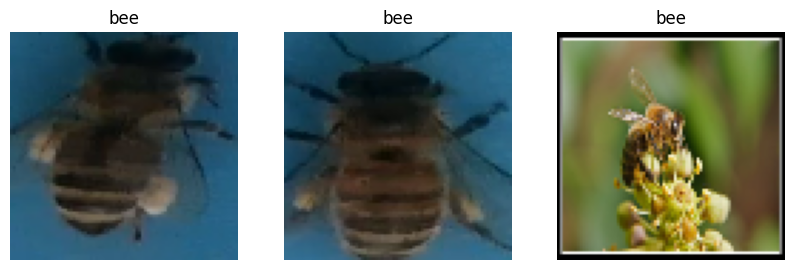

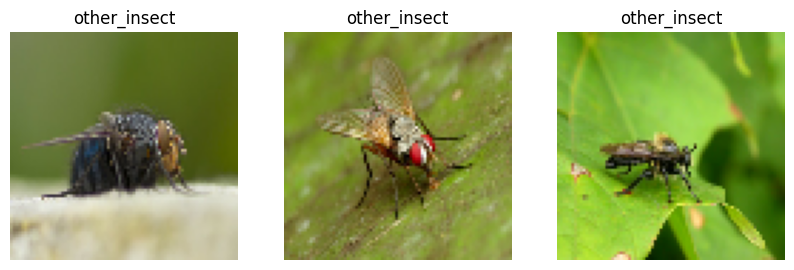

<Figure size 1000x1000 with 0 Axes>

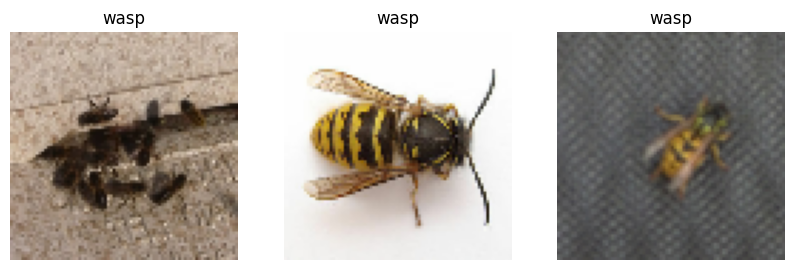

In [4]:
# The data path should be set from the cell above. 
# If that failed and you want to set it manually, use the line below.
# data_path = "data/bee_vs_wasp"


def load_display_data(path, batch_size=32, shape=(80,80,3), show_pictures=True):
    '''Takes a path, batch size, target shape for images and optionally whether to show sample images.
       Returns training and testing datasets
    '''
    print("***********************************************************************")
    print("Load data:")
    print(f"  - Loading the dataset from: {path}.")
    print(f"  - Using a batch size of: {batch_size}.")
    print(f"  - Resizing input images to: {shape}.")
    print("***********************************************************************")
    # Define the directory path
    directory_path = path
    
    # Define the batch size
    batch_size = batch_size
    
    # Define the image size using the 1st 2 elements of the shape parameter
    # We don't need the number of channels here, just the dimensions to use
    image_size = shape[:2]
    
    # Load the dataset
    X_train = tf.keras.preprocessing.image_dataset_from_directory(
        directory_path,
        batch_size=batch_size,
        image_size=image_size,
        validation_split=0.2,
        subset='training',
        seed=123,
        labels='inferred',
        label_mode='int'
    )
    
    X_test = tf.keras.preprocessing.image_dataset_from_directory(
        directory_path,
        batch_size=batch_size,
        image_size=image_size,
        validation_split=0.2,
        subset='validation',
        seed=123,
        labels='inferred',
        label_mode='int'
    )

    if show_pictures:
        # Get the class names
        class_names = X_train.class_names
        print(class_names)

        # Display up to 3 images from each of the categories
        for i, class_name in enumerate(class_names):
            plt.figure(figsize=(10, 10))
            for images, labels in X_train.take(1):
                images = images.numpy()
                labels = labels.numpy()

                # Filter images of the current class
                class_images = images[labels == i]
                
                # Number of images to show.
                # Limited by number of this class in the batch or specific number
                num_images = min(len(class_images), 3)
                
                for j in range(num_images):
                    ax = plt.subplot(1, num_images, j + 1)
                    plt.imshow(class_images[j].astype("uint8"))
                    plt.title(class_name)
                    plt.axis("off")
            plt.show()
    return X_train, X_test

X_train, X_test = load_display_data(data_path, batch_size=32, shape=(80,80,3), show_pictures=True)


## 4. Make our model

This function creates the model we will use.

One hyperparameter to explore is the activation function, which is set when making the model. We start with a ReLU as the default, but you can try others. For simplicity, we will use the same activation function for all but the last layer of the model, but you could change them individually.

The last layer will almost always use a Softmax, which makes all the output values between 0 and 1 and sum to 1, transforming them into probabilities of the input belonging to each possible class.

In [5]:
def make_model(activation='relu', shape=(80,80,3), num_classes=4):
    '''Sets up a model. 
          Takes in an activation function, shape for the input images, and number of classes.
          Returns the model.
    '''
    print("***********************************************************************")
    print("Make model:")
    print(f"  - Using the activation function: {activation}.")
    print(f"  - Model will have {num_classes} classes.")
    print("***********************************************************************")
    
    # Define the model
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation=activation, input_shape=shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation=activation),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation=activation),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation=activation),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

model = make_model()
model.summary()

***********************************************************************
Make model:
  - Using the activation function: relu.
  - Model will have 4 classes.
***********************************************************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 39, 39, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 18, 18, 64)        0         
 g2D)                                                            
                          

## 5. Compile and train the model

This step compiles the model, getting it ready for training. The primary hyperparameters here are:
* the **loss function** (how we determine how close the predicted output is from the known output values),
* the **optimization function** (how we determine what parameters should be updated and how),
* the **learning rate** (how much each parameter should be adjusted), 
* and how many **epochs** should be run (remember, an epoch is a full pass through all the training data). 

In [6]:

# Define a function that takes an optimizer name as a string
def load_optimizer(optimizer_name):
  # Check if the optimizer name is valid
  if optimizer_name in tf.keras.optimizers.__dict__:
    # Return the corresponding optimizer function
    return tf.keras.optimizers.__dict__[optimizer_name]
  else:
    # Raise an exception if the optimizer name is invalid
    raise ValueError(f"Invalid optimizer name: {optimizer_name}")

def compile_train_model(X_train, X_test, model,
                        loss=SparseCategoricalCrossentropy(from_logits=True),
                        optimizer='Adam', learning_rate=0.0001, epochs=10):
    '''Compiles and trains the model. 
          Takes in an X_train, X_test, model, loss function, optimizer, learning rate,
          and epochs.
          Returns the compiled model and training history.
    '''
    print("***********************************************************************")
    print("Compile and Train the model:")
    print(f"  - Using the loss funtion: {loss}.")
    print(f"  - Using the optimizer: {optimizer}.")
    print(f"  - Using learning rate of: {learning_rate}.")
    print(f"  - Running for {epochs} epochs.")
    print("***********************************************************************")
    # Compile the model
    
    opt = load_optimizer(optimizer)(learning_rate=learning_rate)
    
    model.compile(optimizer=opt,
                  loss=loss,
                  metrics=['accuracy'])
    # Train the model
    history = model.fit(X_train, epochs=epochs, validation_data=X_test)
    
    return model, history

model, history = compile_train_model(X_train, X_test, model)

***********************************************************************
Compile and Train the model:
  - Using the loss funtion: <keras.src.losses.SparseCategoricalCrossentropy object at 0x7f26b415f670>.
  - Using the optimizer: Adam.
  - Using learning rate of: 0.0001.
  - Running for 10 epochs.
***********************************************************************
Epoch 1/10


/project/scinet_workshop2/deep_learning_env/lib64/python3.9/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-01-10 12:50:32.570747: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-10 12:50:33.033763: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-10 12:50:33.540062: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2654a56000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-10 12:50:33.540095: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB MIG 1g.10gb, Compute Capability 8.0
2024-01-10 12:50:33.544641: I tensorflow/comp

286/286 [==============================] - 9s 16ms/step - loss: 2.1039 - accuracy: 0.5418 - val_loss: 1.0440 - val_accuracy: 0.6016
Epoch 2/10
286/286 [==============================] - 4s 12ms/step - loss: 0.9124 - accuracy: 0.6577 - val_loss: 0.8979 - val_accuracy: 0.6611
Epoch 3/10
286/286 [==============================] - 4s 12ms/step - loss: 0.7312 - accuracy: 0.7148 - val_loss: 0.8565 - val_accuracy: 0.6756
Epoch 4/10
286/286 [==============================] - 4s 12ms/step - loss: 0.6193 - accuracy: 0.7647 - val_loss: 0.8166 - val_accuracy: 0.7053
Epoch 5/10
286/286 [==============================] - 4s 14ms/step - loss: 0.5165 - accuracy: 0.8058 - val_loss: 0.8595 - val_accuracy: 0.6979
Epoch 6/10
286/286 [==============================] - 4s 12ms/step - loss: 0.4234 - accuracy: 0.8427 - val_loss: 0.9581 - val_accuracy: 0.6992
Epoch 7/10
286/286 [==============================] - 4s 12ms/step - loss: 0.3711 - accuracy: 0.8632 - val_loss: 0.8795 - val_accuracy: 0.7198
Epoch 8/10

## 6. Evaluate the model

Now that we have trained our model, let's evaluate how it does.


***********************************************************************
Evaluate the model:
***********************************************************************
72/72 [==============================] - 1s 9ms/step - loss: 0.9659 - accuracy: 0.7202
Test loss: 0.9658552408218384
Test accuracy: 0.7202276587486267


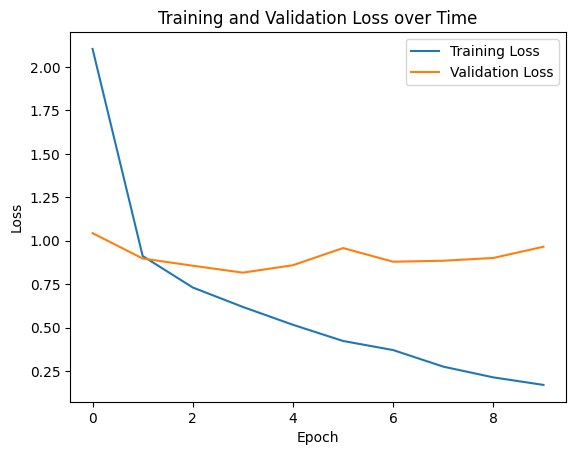

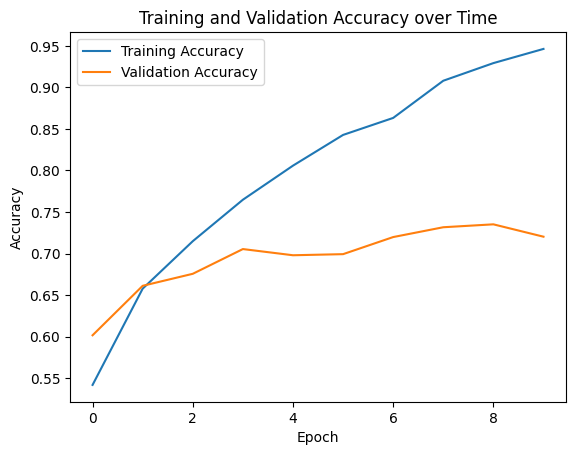

72/72 [==============================] - 1s 9ms/step


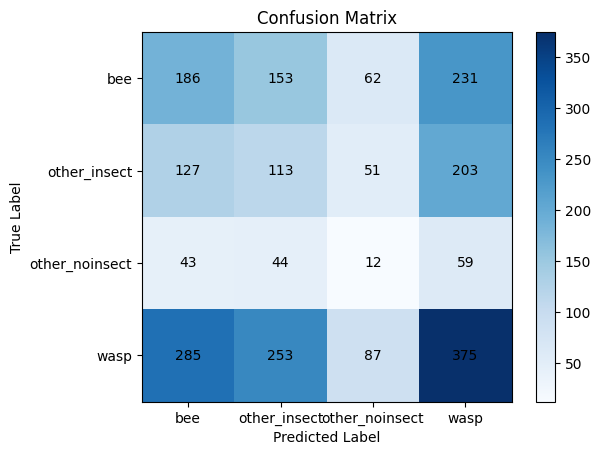

In [7]:
def evaluate_model(X_train, X_test, model, history, num_classes=4):
    '''Evaluates a model. 
          Takes in an X_train, X_test, model, history, number of classes.
    '''
    print("***********************************************************************")
    print("Evaluate the model:")
    print("***********************************************************************")
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test)
    print(f'Test loss: {loss}')
    print(f'Test accuracy: {accuracy}')


    # Plot the training and validation loss over time
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot the training and validation accuracy over time
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Get the class names
    class_names = X_test.class_names

    # Make predictions on the test set
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    
    # Get the true labels
    y_true = np.concatenate([y for x, y in X_test], axis=0)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot the confusion matrix
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(range(num_classes),class_names)
    plt.yticks(range(num_classes), class_names)
    plt.colorbar()
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
    plt.show()

evaluate_model(X_train, X_test, model, history)

## 7. Explore hyperparameters!

OK, we've trained the model once using some decent first guesses. Now, we can see if we can do better by exploring different hyperparameters.

While there are methods to explore different hyperparameters systematically and track the results more efficiently, we will rely on some ad-hoc exploration and keep everything in the notebook.

The following function pulls all the steps from above into a single function.

In [8]:
def the_whole_shebang(path, batch_size, shape, classes, activation, loss, optimizer, show_pictures=True):
    
    X_train, X_test = load_display_data(path, batch_size, shape, show_pictures)
    model = make_model(activation=activation, shape=shape, num_classes=classes)
    model, history = compile_train_model(X_train, X_test, model, loss=loss,
                        optimizer=optimizer, learning_rate=learning_rate, epochs=epochs)
    evaluate_model(X_train, X_test, model, history, classes)

### Copy the next cell and change hyperparameters

You can copy the next cell multiple times and adjust the hyperparameters to compare results.

***********************************************************************
Load data:
  - Loading the dataset from: /project/scinet_workshop2/data/bee_vs_wasp.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
***********************************************************************
Found 11422 files belonging to 4 classes.
Using 9138 files for training.
Found 11422 files belonging to 4 classes.
Using 2284 files for validation.
['bee', 'other_insect', 'other_noinsect', 'wasp']


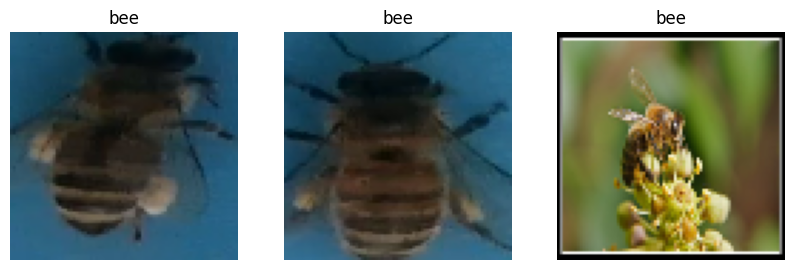

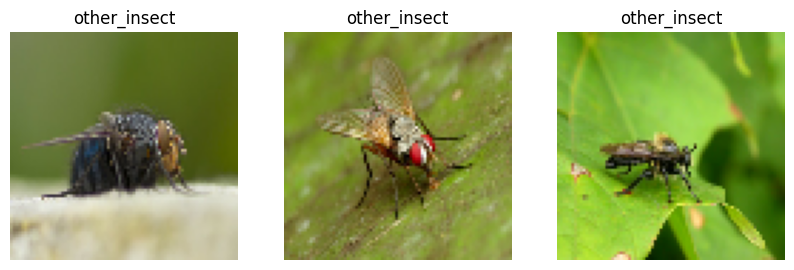

<Figure size 1000x1000 with 0 Axes>

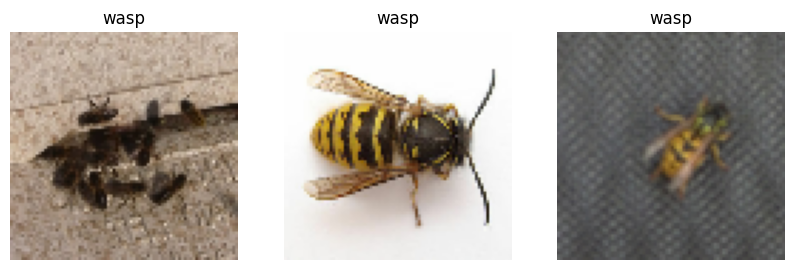

***********************************************************************
Make model:
  - Using the activation function: relu.
  - Model will have 4 classes.
***********************************************************************
***********************************************************************
Compile and Train the model:
  - Using the loss funtion: <keras.src.losses.SparseCategoricalCrossentropy object at 0x7f26c48592e0>.
  - Using the optimizer: Adam.
  - Using learning rate of: 0.001.
  - Running for 10 epochs.
***********************************************************************
Epoch 1/10


/project/scinet_workshop2/deep_learning_env/lib64/python3.9/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


286/286 [==============================] - 5s 14ms/step - loss: 2.1779 - accuracy: 0.5823 - val_loss: 0.8871 - val_accuracy: 0.6370
Epoch 2/10
286/286 [==============================] - 4s 14ms/step - loss: 0.7947 - accuracy: 0.6813 - val_loss: 0.7973 - val_accuracy: 0.6905
Epoch 3/10
286/286 [==============================] - 4s 15ms/step - loss: 0.7022 - accuracy: 0.7221 - val_loss: 0.9244 - val_accuracy: 0.6799
Epoch 4/10
286/286 [==============================] - 4s 15ms/step - loss: 0.5999 - accuracy: 0.7699 - val_loss: 0.9612 - val_accuracy: 0.6743
Epoch 5/10
286/286 [==============================] - 4s 14ms/step - loss: 0.4947 - accuracy: 0.8117 - val_loss: 0.8490 - val_accuracy: 0.7180
Epoch 6/10
286/286 [==============================] - 4s 13ms/step - loss: 0.3969 - accuracy: 0.8525 - val_loss: 0.9500 - val_accuracy: 0.7053
Epoch 7/10
286/286 [==============================] - 4s 13ms/step - loss: 0.3281 - accuracy: 0.8762 - val_loss: 1.0033 - val_accuracy: 0.7285
Epoch 8/10

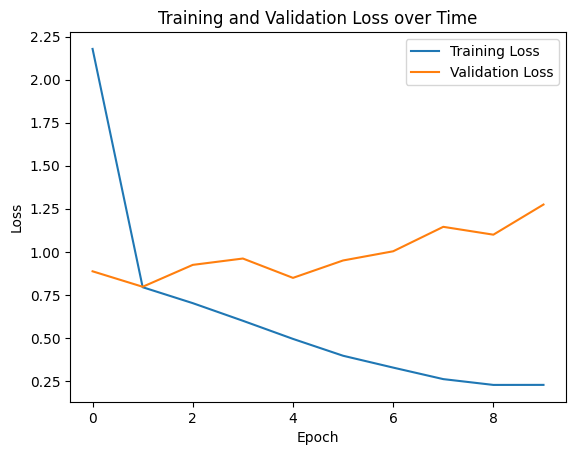

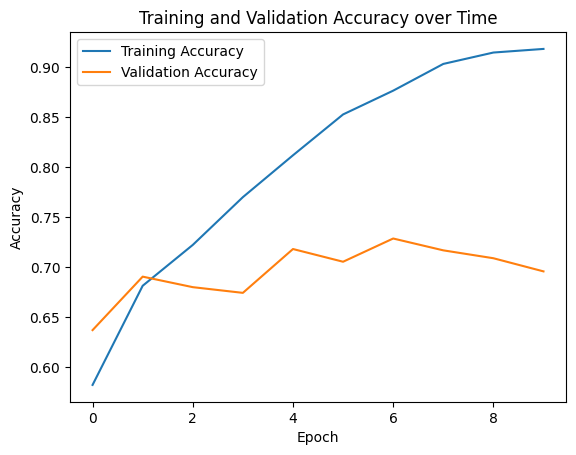

72/72 [==============================] - 1s 10ms/step


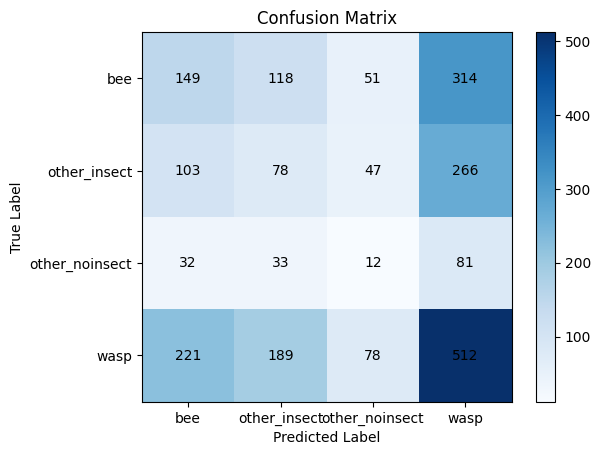

In [9]:
#data_path = 'data/bee_vs_wasp/' # Path to the data.
        # This is defined above, only need to change if you change datasets
    
show_pictures = True # Show sample images from the dataset? Keep on at first, but may become distracting.
                     # Set to False to turn off
# Hyperparameters
shape = (80,80,3)  # Dimensions to use for the images...the raw data are 80x80
                   #  color images, but you could down-sample them
                   #  or convert them to black and white if you wanted
batch_size = 32  # What batch size to use
classes = 4 # We have 4 classes in our dataset: bee, wasp, other_insect, other_noninsect
            # Only change this if you change the dataset
activation='relu' # The activation function is an important hyperparameter
                  # Other activations functions to try: tanh, sigmoid

loss = SparseCategoricalCrossentropy(from_logits=True) # Loss function
        # Other loss functions to try: losses.CategoricalHinge()
        #                              losses.KLDivergence()

optimizer = 'Adam' # Optimizer: others to try: Adam, RMSprop, Adagrad 

learning_rate = 0.001 # Try increasing or decreasing the learning rate by an order of magnitude

epochs = 10 # Try running more epochs

# Run everything with these hyperparameters
the_whole_shebang(data_path, batch_size, shape, classes, activation, loss, optimizer, show_pictures)

***********************************************************************
Load data:
  - Loading the dataset from: /project/scinet_workshop2/data/bee_vs_wasp.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
***********************************************************************
Found 11422 files belonging to 4 classes.
Using 9138 files for training.
Found 11422 files belonging to 4 classes.
Using 2284 files for validation.
['bee', 'other_insect', 'other_noinsect', 'wasp']


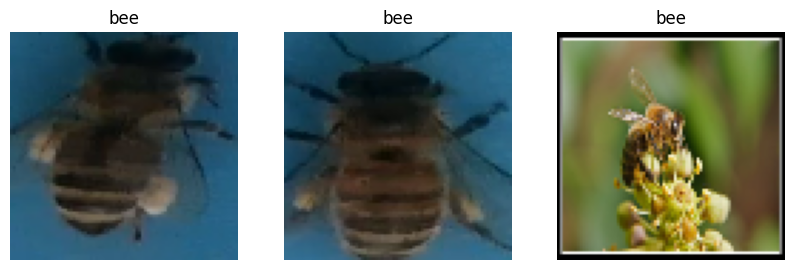

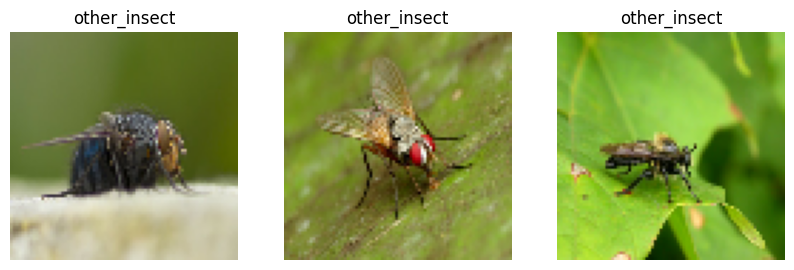

<Figure size 1000x1000 with 0 Axes>

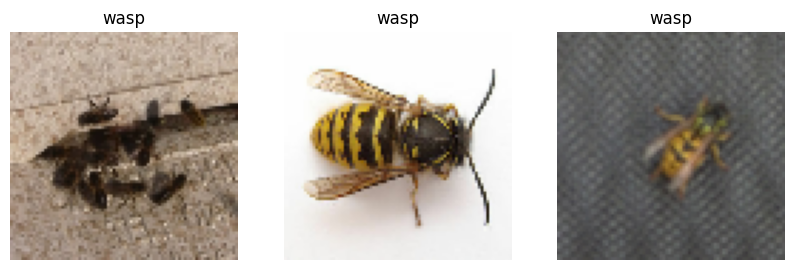

***********************************************************************
Make model:
  - Using the activation function: relu.
  - Model will have 4 classes.
***********************************************************************
***********************************************************************
Compile and Train the model:
  - Using the loss funtion: <keras.src.losses.SparseCategoricalCrossentropy object at 0x7f26b41b4fa0>.
  - Using the optimizer: Adagrad.
  - Using learning rate of: 0.01.
  - Running for 10 epochs.
***********************************************************************
Epoch 1/10


/project/scinet_workshop2/deep_learning_env/lib64/python3.9/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


286/286 [==============================] - 4s 12ms/step - loss: 10.0666 - accuracy: 0.5836 - val_loss: 0.9545 - val_accuracy: 0.6081
Epoch 2/10
286/286 [==============================] - 4s 12ms/step - loss: 0.7974 - accuracy: 0.6851 - val_loss: 0.8797 - val_accuracy: 0.6506
Epoch 3/10
286/286 [==============================] - 4s 14ms/step - loss: 0.7182 - accuracy: 0.7217 - val_loss: 0.7728 - val_accuracy: 0.6966
Epoch 4/10
286/286 [==============================] - 4s 13ms/step - loss: 0.6513 - accuracy: 0.7439 - val_loss: 0.7164 - val_accuracy: 0.7102
Epoch 5/10
286/286 [==============================] - 4s 12ms/step - loss: 0.5974 - accuracy: 0.7701 - val_loss: 0.7476 - val_accuracy: 0.7110
Epoch 6/10
286/286 [==============================] - 4s 14ms/step - loss: 0.5437 - accuracy: 0.7946 - val_loss: 0.7586 - val_accuracy: 0.7036
Epoch 7/10
286/286 [==============================] - 4s 12ms/step - loss: 0.4888 - accuracy: 0.8129 - val_loss: 0.7064 - val_accuracy: 0.7294
Epoch 8/1

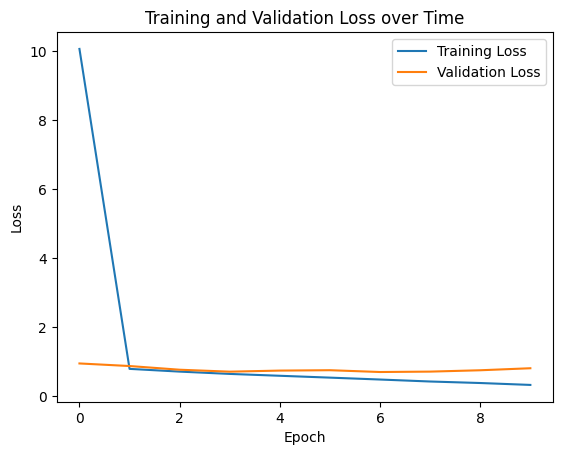

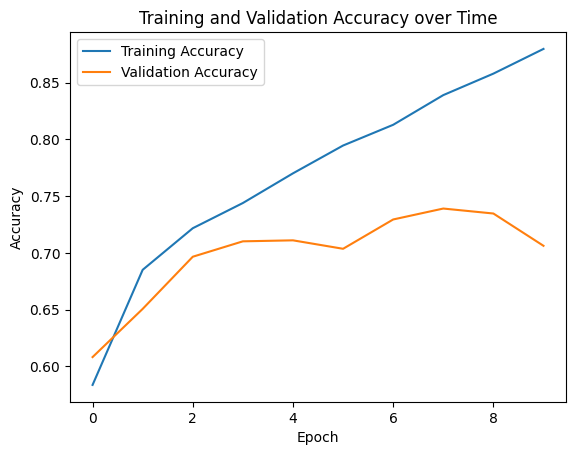

72/72 [==============================] - 1s 9ms/step


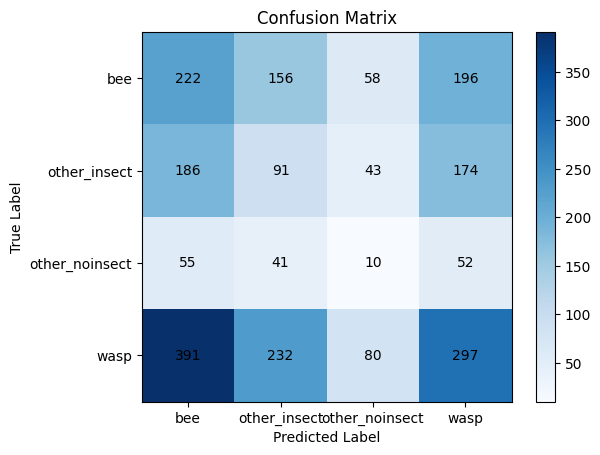

In [10]:
#data_path = 'data/bee_vs_wasp/' # Path to the data.
        # This is defined above, only need to change if you change datasets
    
show_pictures = True # Show sample images from the dataset? Keep on at first, but may become distracting.
                     # Set to False to turn off
# Hyperparameters
shape = (80,80,3)  # Dimensions to use for the images...the raw data are 80x80
                   #  color images, but you could down-sample them
                   #  or convert them to black and white if you wanted
batch_size = 32  # What batch size to use
classes = 4 # We have 4 classes in our dataset: bee, wasp, other_insect, other_noninsect
            # Only change this if you change the dataset
activation='relu' # The activation function is an important hyperparameter
                  # Other activations functions to try: tanh, sigmoid

loss = SparseCategoricalCrossentropy(from_logits=True) # Loss function
        # Other loss functions to try: losses.CategoricalHinge()
        #                              losses.KLDivergence()

optimizer = 'Adagrad' # Optimizer: others to try: Adam, RMSprop, Adagrad 

learning_rate = 0.010 # Try increasing or decreasing the learning rate by an order of magnitude

epochs = 10 # Try running more epochs

# Run everything with these hyperparameters
the_whole_shebang(data_path, batch_size, shape, classes, activation, loss, optimizer, show_pictures)

***********************************************************************
Load data:
  - Loading the dataset from: /project/scinet_workshop2/data/bee_vs_wasp.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
***********************************************************************
Found 11422 files belonging to 4 classes.
Using 9138 files for training.
Found 11422 files belonging to 4 classes.
Using 2284 files for validation.
['bee', 'other_insect', 'other_noinsect', 'wasp']


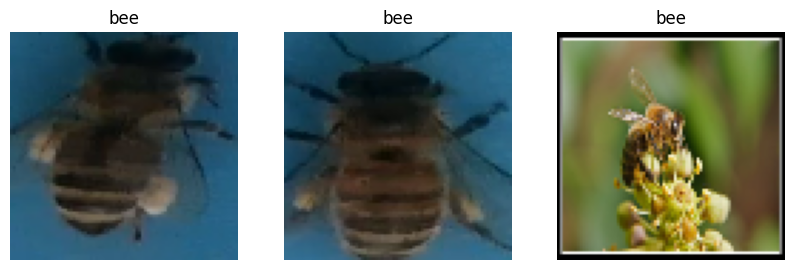

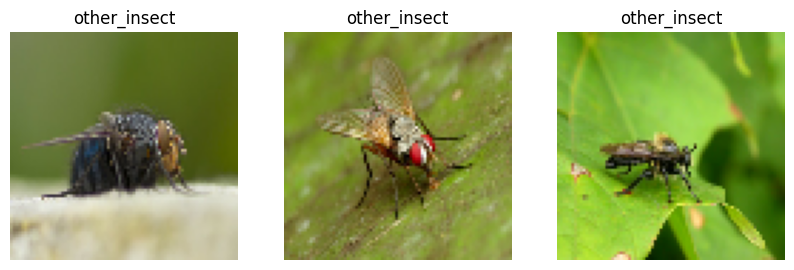

<Figure size 1000x1000 with 0 Axes>

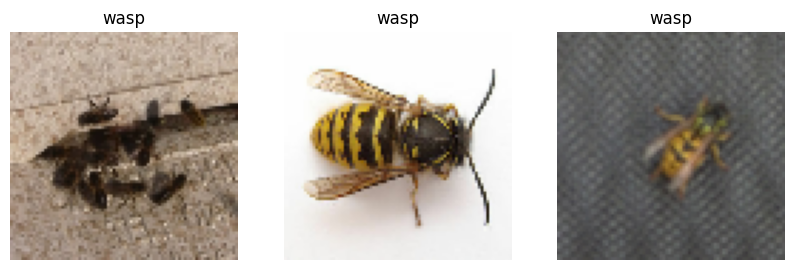

***********************************************************************
Make model:
  - Using the activation function: relu.
  - Model will have 4 classes.
***********************************************************************
***********************************************************************
Compile and Train the model:
  - Using the loss funtion: <keras.src.losses.SparseCategoricalCrossentropy object at 0x7f26a42bac10>.
  - Using the optimizer: RMSprop.
  - Using learning rate of: 0.001.
  - Running for 10 epochs.
***********************************************************************
Epoch 1/10


/project/scinet_workshop2/deep_learning_env/lib64/python3.9/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


286/286 [==============================] - 5s 13ms/step - loss: 7.0664 - accuracy: 0.4955 - val_loss: 1.4908 - val_accuracy: 0.5215
Epoch 2/10
286/286 [==============================] - 4s 13ms/step - loss: 0.8945 - accuracy: 0.6499 - val_loss: 1.0266 - val_accuracy: 0.6699
Epoch 3/10
286/286 [==============================] - 4s 13ms/step - loss: 0.7649 - accuracy: 0.7046 - val_loss: 0.7562 - val_accuracy: 0.7163
Epoch 4/10
286/286 [==============================] - 4s 13ms/step - loss: 0.6870 - accuracy: 0.7405 - val_loss: 0.7553 - val_accuracy: 0.7320
Epoch 5/10
286/286 [==============================] - 4s 13ms/step - loss: 0.6229 - accuracy: 0.7658 - val_loss: 0.7540 - val_accuracy: 0.7382
Epoch 6/10
286/286 [==============================] - 4s 13ms/step - loss: 0.5402 - accuracy: 0.8018 - val_loss: 0.9730 - val_accuracy: 0.5740
Epoch 7/10
286/286 [==============================] - 4s 15ms/step - loss: 0.4933 - accuracy: 0.8224 - val_loss: 1.0769 - val_accuracy: 0.7123
Epoch 8/10

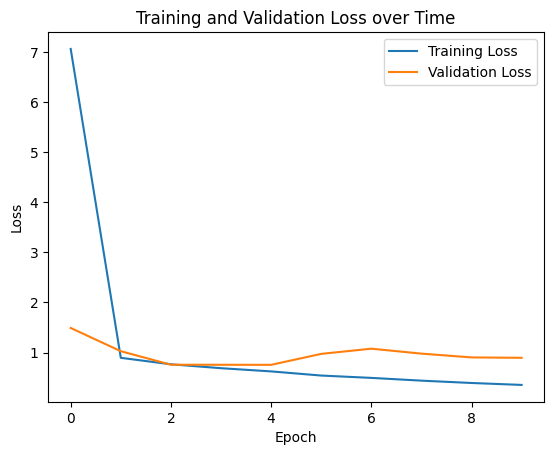

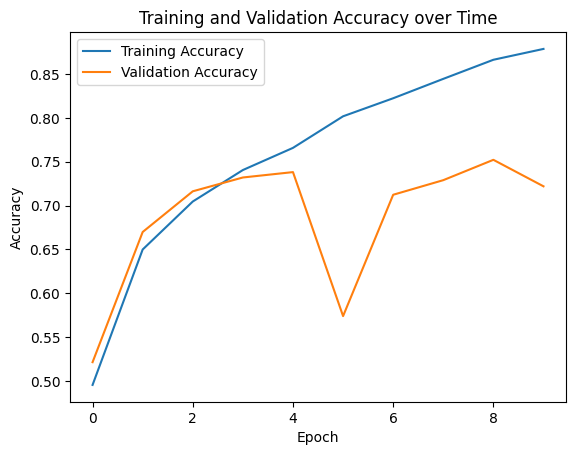

72/72 [==============================] - 1s 9ms/step


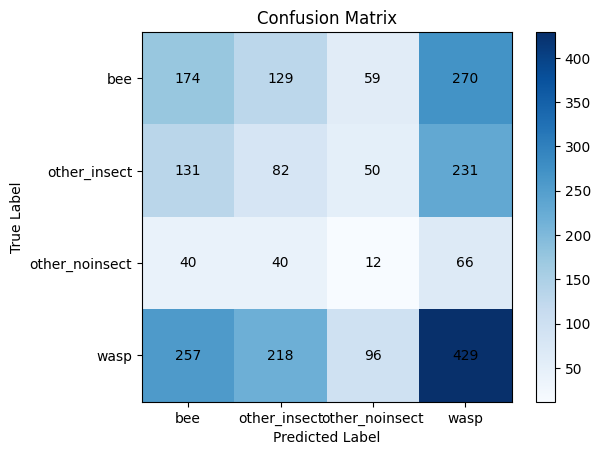

In [11]:
#data_path = 'data/bee_vs_wasp/' # Path to the data.
        # This is defined above, only need to change if you change datasets
    
show_pictures = True # Show sample images from the dataset? Keep on at first, but may become distracting.
                     # Set to False to turn off
# Hyperparameters
shape = (80,80,3)  # Dimensions to use for the images...the raw data are 80x80
                   #  color images, but you could down-sample them
                   #  or convert them to black and white if you wanted
batch_size = 32  # What batch size to use
classes = 4 # We have 4 classes in our dataset: bee, wasp, other_insect, other_noninsect
            # Only change this if you change the dataset
activation='relu' # The activation function is an important hyperparameter
                  # Other activations functions to try: tanh, sigmoid

loss = SparseCategoricalCrossentropy(from_logits=True) # Loss function
        # Other loss functions to try: losses.CategoricalHinge()
        #                              losses.KLDivergence()

optimizer = 'RMSprop' # Optimizer: others to try: Adam, RMSprop, Adagrad 

learning_rate = 0.001 # Try increasing or decreasing the learning rate by an order of magnitude

epochs = 10 # Try running more epochs

# Run everything with these hyperparameters
the_whole_shebang(data_path, batch_size, shape, classes, activation, loss, optimizer, show_pictures)

***********************************************************************
Load data:
  - Loading the dataset from: /project/scinet_workshop2/data/bee_vs_wasp.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
***********************************************************************
Found 11422 files belonging to 4 classes.
Using 9138 files for training.
Found 11422 files belonging to 4 classes.
Using 2284 files for validation.
['bee', 'other_insect', 'other_noinsect', 'wasp']


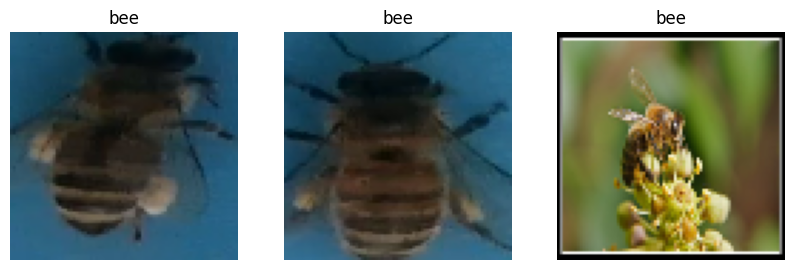

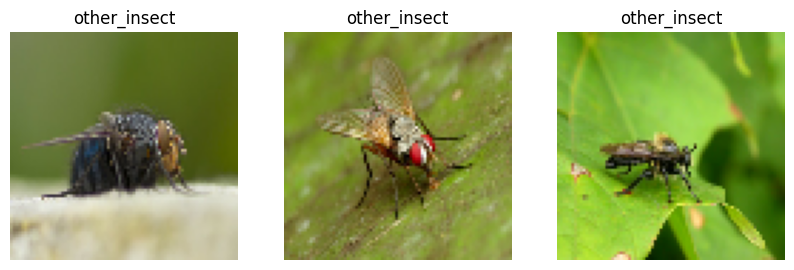

<Figure size 1000x1000 with 0 Axes>

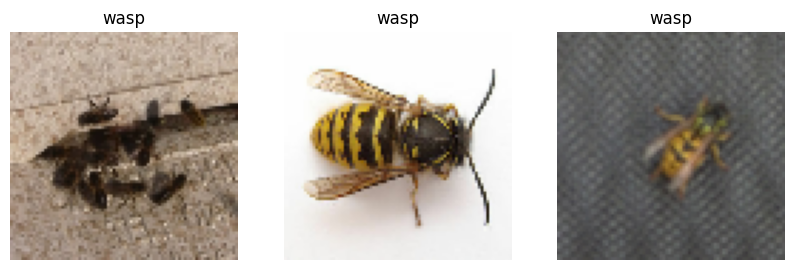

***********************************************************************
Make model:
  - Using the activation function: relu.
  - Model will have 4 classes.
***********************************************************************
***********************************************************************
Compile and Train the model:
  - Using the loss funtion: <keras.src.losses.SparseCategoricalCrossentropy object at 0x7f25e4149970>.
  - Using the optimizer: Adam.
  - Using learning rate of: 0.01.
  - Running for 20 epochs.
***********************************************************************
Epoch 1/20


/project/scinet_workshop2/deep_learning_env/lib64/python3.9/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


286/286 [==============================] - 4s 12ms/step - loss: 13.7549 - accuracy: 0.4247 - val_loss: 1.2342 - val_accuracy: 0.4378
Epoch 2/20
286/286 [==============================] - 5s 16ms/step - loss: 1.2483 - accuracy: 0.4316 - val_loss: 1.2344 - val_accuracy: 0.4383
Epoch 3/20
286/286 [==============================] - 4s 13ms/step - loss: 1.2462 - accuracy: 0.4316 - val_loss: 1.2374 - val_accuracy: 0.4378
Epoch 4/20
286/286 [==============================] - 4s 13ms/step - loss: 1.2448 - accuracy: 0.4328 - val_loss: 1.2425 - val_accuracy: 0.4378
Epoch 5/20
286/286 [==============================] - 4s 14ms/step - loss: 1.2437 - accuracy: 0.4331 - val_loss: 1.2619 - val_accuracy: 0.4405
Epoch 6/20
286/286 [==============================] - 4s 13ms/step - loss: 1.2424 - accuracy: 0.4338 - val_loss: 1.2709 - val_accuracy: 0.4387
Epoch 7/20
286/286 [==============================] - 4s 13ms/step - loss: 1.2419 - accuracy: 0.4343 - val_loss: 1.2857 - val_accuracy: 0.4387
Epoch 8/2

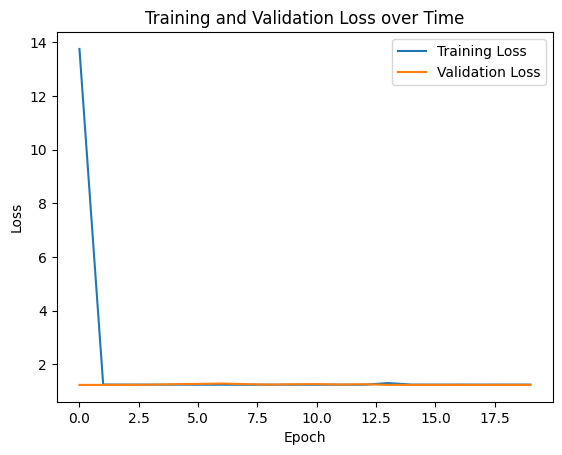

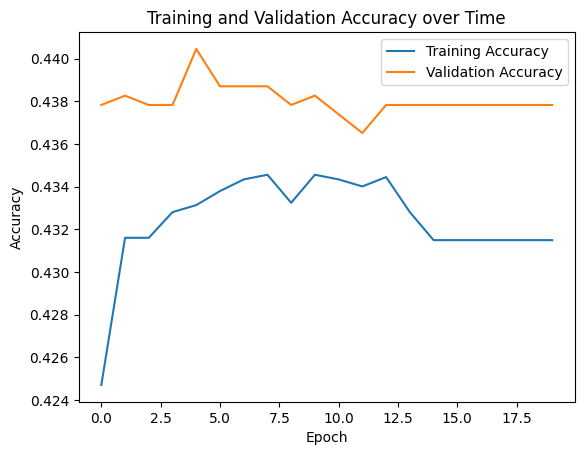

72/72 [==============================] - 1s 9ms/step


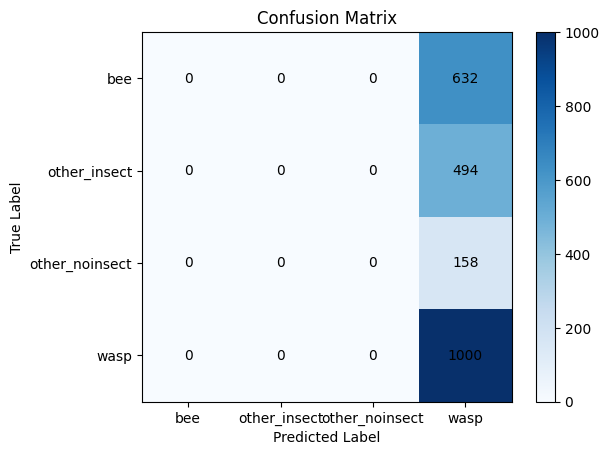

In [12]:
#data_path = 'data/bee_vs_wasp/' # Path to the data.
        # This is defined above, only need to change if you change datasets
    
show_pictures = True # Show sample images from the dataset? Keep on at first, but may become distracting.
                     # Set to False to turn off
# Hyperparameters
shape = (80,80,3)  # Dimensions to use for the images...the raw data are 80x80
                   #  color images, but you could down-sample them
                   #  or convert them to black and white if you wanted
batch_size = 32  # What batch size to use
classes = 4 # We have 4 classes in our dataset: bee, wasp, other_insect, other_noninsect
            # Only change this if you change the dataset
activation='relu' # The activation function is an important hyperparameter
                  # Other activations functions to try: tanh, sigmoid

loss = SparseCategoricalCrossentropy(from_logits=True) # Loss function
        # Other loss functions to try: losses.CategoricalHinge()
        #                              losses.KLDivergence()

optimizer = 'Adam' # Optimizer: others to try: Adam, RMSprop, Adagrad 

learning_rate = 0.010 # Try increasing or decreasing the learning rate by an order of magnitude

epochs = 20 # Try running more epochs

# Run everything with these hyperparameters
the_whole_shebang(data_path, batch_size, shape, classes, activation, loss, optimizer, show_pictures)

***********************************************************************
Load data:
  - Loading the dataset from: /project/scinet_workshop2/data/bee_vs_wasp.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
***********************************************************************
Found 11422 files belonging to 4 classes.
Using 9138 files for training.
Found 11422 files belonging to 4 classes.
Using 2284 files for validation.
['bee', 'other_insect', 'other_noinsect', 'wasp']


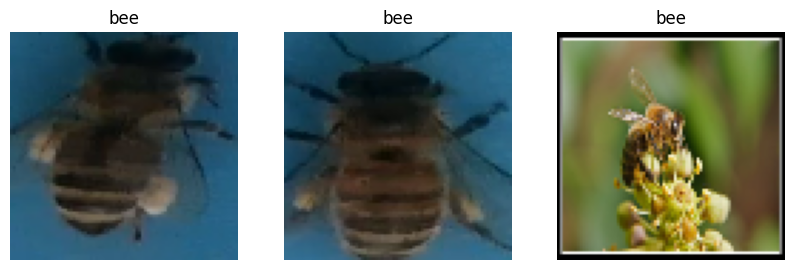

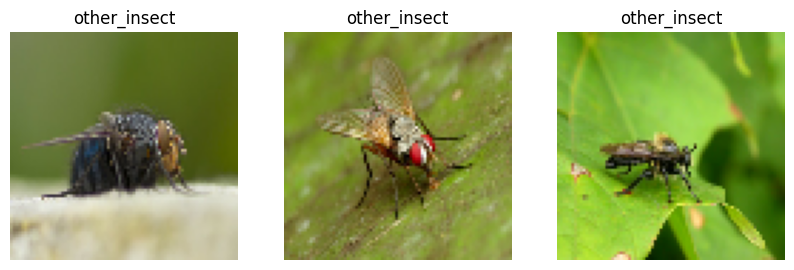

<Figure size 1000x1000 with 0 Axes>

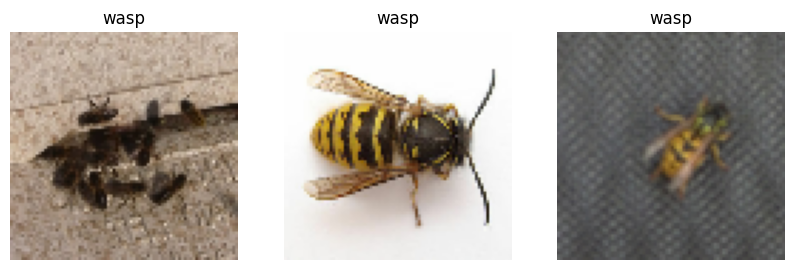

***********************************************************************
Make model:
  - Using the activation function: sigmoid.
  - Model will have 4 classes.
***********************************************************************
***********************************************************************
Compile and Train the model:
  - Using the loss funtion: <keras.src.losses.SparseCategoricalCrossentropy object at 0x7f25e4152340>.
  - Using the optimizer: Adagrad.
  - Using learning rate of: 0.001.
  - Running for 10 epochs.
***********************************************************************
Epoch 1/10


/project/scinet_workshop2/deep_learning_env/lib64/python3.9/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


286/286 [==============================] - 7s 21ms/step - loss: 1.2497 - accuracy: 0.4307 - val_loss: 1.2395 - val_accuracy: 0.4378
Epoch 2/10
286/286 [==============================] - 4s 13ms/step - loss: 1.2475 - accuracy: 0.4313 - val_loss: 1.2355 - val_accuracy: 0.4378
Epoch 3/10
286/286 [==============================] - 4s 14ms/step - loss: 1.2467 - accuracy: 0.4315 - val_loss: 1.2359 - val_accuracy: 0.4378
Epoch 4/10
286/286 [==============================] - 4s 13ms/step - loss: 1.2458 - accuracy: 0.4315 - val_loss: 1.2388 - val_accuracy: 0.4378
Epoch 5/10
286/286 [==============================] - 4s 14ms/step - loss: 1.2453 - accuracy: 0.4308 - val_loss: 1.2338 - val_accuracy: 0.4378
Epoch 6/10
286/286 [==============================] - 4s 14ms/step - loss: 1.2453 - accuracy: 0.4315 - val_loss: 1.2352 - val_accuracy: 0.4378
Epoch 7/10
286/286 [==============================] - 5s 16ms/step - loss: 1.2438 - accuracy: 0.4313 - val_loss: 1.2355 - val_accuracy: 0.4378
Epoch 8/10

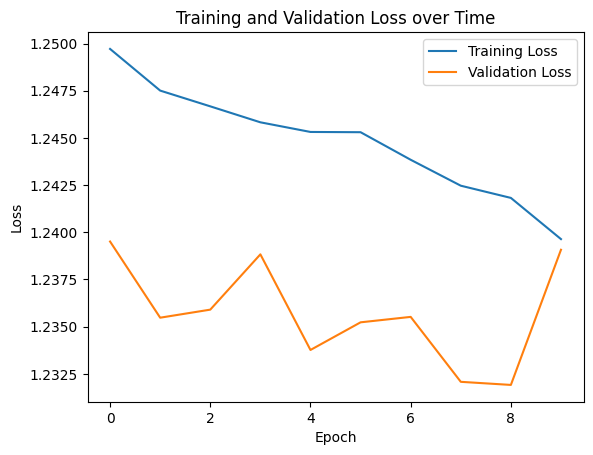

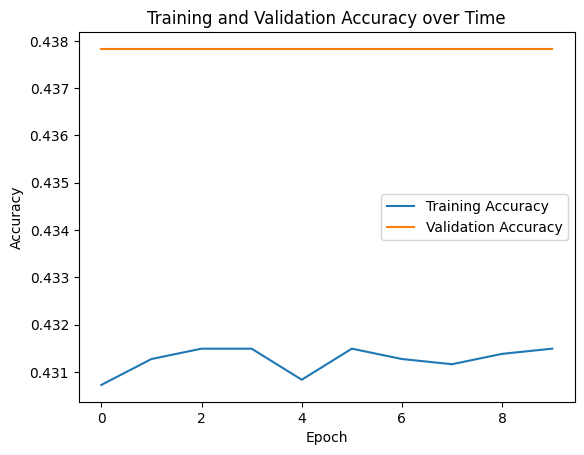

72/72 [==============================] - 1s 9ms/step


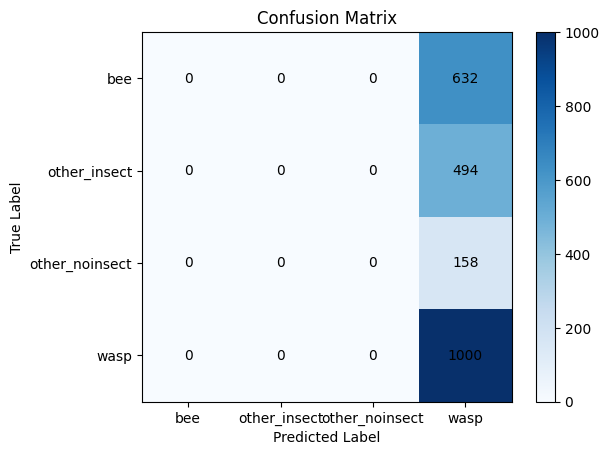

In [13]:
#data_path = 'data/bee_vs_wasp/' # Path to the data.
        # This is defined above, only need to change if you change datasets
    
show_pictures = True # Show sample images from the dataset? Keep on at first, but may become distracting.
                     # Set to False to turn off
# Hyperparameters
shape = (80,80,3)  # Dimensions to use for the images...the raw data are 80x80
                   #  color images, but you could down-sample them
                   #  or convert them to black and white if you wanted
batch_size = 32  # What batch size to use
classes = 4 # We have 4 classes in our dataset: bee, wasp, other_insect, other_noninsect
            # Only change this if you change the dataset
activation='sigmoid' # The activation function is an important hyperparameter
                  # Other activations functions to try: tanh, sigmoid

loss = SparseCategoricalCrossentropy(from_logits=True) # Loss function
        # Other loss functions to try: losses.CategoricalHinge()
        #                              losses.KLDivergence()

optimizer = 'Adagrad' # Optimizer: others to try: Adam, RMSprop, Adagrad 

learning_rate = 0.001 # Try increasing or decreasing the learning rate by an order of magnitude

epochs = 10 # Try running more epochs

# Run everything with these hyperparameters
the_whole_shebang(data_path, batch_size, shape, classes, activation, loss, optimizer, show_pictures)

In [ ]:
#data_path = 'data/bee_vs_wasp/' # Path to the data.
        # This is defined above, only need to change if you change datasets
    
show_pictures = True # Show sample images from the dataset? Keep on at first, but may become distracting.
                     # Set to False to turn off
# Hyperparameters
shape = (80,80,3)  # Dimensions to use for the images...the raw data are 80x80
                   #  color images, but you could down-sample them
                   #  or convert them to black and white if you wanted
batch_size = 32  # What batch size to use
classes = 4 # We have 4 classes in our dataset: bee, wasp, other_insect, other_noninsect
            # Only change this if you change the dataset
activation='relu' # The activation function is an important hyperparameter
                  # Other activations functions to try: tanh, sigmoid

loss = SparseCategoricalCrossentropy(from_logits=True) # Loss function
        # Other loss functions to try: losses.CategoricalHinge()
        #                              losses.KLDivergence()

optimizer = 'Adagrad' # Optimizer: others to try: Adam, RMSprop, Adagrad 

learning_rate = 0.001 # Try increasing or decreasing the learning rate by an order of magnitude

epochs = 10 # Try running more epochs

# Run everything with these hyperparameters
the_whole_shebang(data_path, batch_size, shape, classes, activation, loss, optimizer, show_pictures)

In [ ]:
#data_path = 'data/bee_vs_wasp/' # Path to the data.
        # This is defined above, only need to change if you change datasets
    
show_pictures = True # Show sample images from the dataset? Keep on at first, but may become distracting.
                     # Set to False to turn off
# Hyperparameters
shape = (80,80,3)  # Dimensions to use for the images...the raw data are 80x80
                   #  color images, but you could down-sample them
                   #  or convert them to black and white if you wanted
batch_size = 32  # What batch size to use
classes = 4 # We have 4 classes in our dataset: bee, wasp, other_insect, other_noninsect
            # Only change this if you change the dataset
activation='relu' # The activation function is an important hyperparameter
                  # Other activations functions to try: tanh, sigmoid

loss = SparseCategoricalCrossentropy(from_logits=True) # Loss function
        # Other loss functions to try: losses.CategoricalHinge()
        #                              losses.KLDivergence()

optimizer = 'Adagrad' # Optimizer: others to try: Adam, RMSprop, Adagrad 

learning_rate = 0.001 # Try increasing or decreasing the learning rate by an order of magnitude

epochs = 10 # Try running more epochs

# Run everything with these hyperparameters
the_whole_shebang(data_path, batch_size, shape, classes, activation, loss, optimizer, show_pictures)

In [ ]:
#data_path = 'data/bee_vs_wasp/' # Path to the data.
        # This is defined above, only need to change if you change datasets
    
show_pictures = True # Show sample images from the dataset? Keep on at first, but may become distracting.
                     # Set to False to turn off
# Hyperparameters
shape = (80,80,3)  # Dimensions to use for the images...the raw data are 80x80
                   #  color images, but you could down-sample them
                   #  or convert them to black and white if you wanted
batch_size = 32  # What batch size to use
classes = 4 # We have 4 classes in our dataset: bee, wasp, other_insect, other_noninsect
            # Only change this if you change the dataset
activation='relu' # The activation function is an important hyperparameter
                  # Other activations functions to try: tanh, sigmoid

loss = SparseCategoricalCrossentropy(from_logits=True) # Loss function
        # Other loss functions to try: losses.CategoricalHinge()
        #                              losses.KLDivergence()

optimizer = 'Adagrad' # Optimizer: others to try: Adam, RMSprop, Adagrad 

learning_rate = 0.001 # Try increasing or decreasing the learning rate by an order of magnitude

epochs = 10 # Try running more epochs

# Run everything with these hyperparameters
the_whole_shebang(data_path, batch_size, shape, classes, activation, loss, optimizer, show_pictures)